In [2]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

from src import dataset, config, layers, warm_start, plot

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
np.random.seed(config.RANDOM_SEED)

In [4]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.num_products,
    config.pallet_lenght, 
    config.pallet_width, 
    config.max_product_height, 
    config.pallet_load
)
product_dataset.products.head()

,lenght,width,height,weight
0,136,79,459,72
1,244,365,491,11
2,96,410,600,4
3,299,119,477,15
4,128,20,502,55


In [5]:
ordered_products = 20
order = product_dataset.get_order(ordered_products)
order.head()

,id,lenght,width,height,weight
0,102,212,339,1090,19
1,435,105,55,158,106
2,860,42,822,95,45
3,270,15,256,907,35
4,106,105,380,369,69


To do:
- Write bin packing heuristics
- Add weight constraints
- Struttura gestione layers
- Ri-implementare generazione del dataset sulla base di quello del paper
- Da coordinate superitem a coordinate item

In [6]:
sample_order = pd.concat([order.sample(1)] * 2 + [order.sample(1)] * 2).reset_index(drop=True)
sample_order

,id,lenght,width,height,weight
0,102,212,339,1090,19
1,102,212,339,1090,19
2,121,221,68,97,52
3,121,221,68,97,52


In [6]:
from ortools.linear_solver import pywraplp

status_string = {
    cp_model.OPTIMAL: 'optimal',
    cp_model.FEASIBLE: 'feasible',
    cp_model.INFEASIBLE: 'infeasible',
    cp_model.MODEL_INVALID: 'invalid',
    cp_model.UNKNOWN: 'unknown'
}

def main_problem(fsi, zsl, ol, tlim=None, relaxation=True):
    # fsi: boolean matrix fsi[s, i] = 1 if superitem s contains item i  
    # zsl: boolean matrix zsl[s, l] = 1 if superitem s is in layer l
    # ol: continuos variables ol[l] = h if layer l has height h
    
    # Solver
    if relaxation:
        slv = pywraplp.Solver.CreateSolver('CLP')
    else:
        slv = pywraplp.Solver.CreateSolver('CBC')
    
    # Utility
    infinity = slv.infinity()
    n_superitems, n_layers = zsl.shape
    n_items = fsi.shape[-1] 
    
    # Variables
    if relaxation:
        al = [
            slv.NumVar(0, infinity, f'alpha_{l}') 
            for l in range(n_layers)
        ]
    else:
        al = [
            slv.IntVar(0, 1, f'alpha_{l}') 
            for l in range(n_layers)
        ]
        
    # Constraints
    for i in range(n_items):
        if relaxation:
            slv.Add(
                -sum(
                    fsi[s, i] * zsl[s, l] * al[l] 
                    for s in range(n_superitems) 
                    for l in range(n_layers)
                ) <= -1
            )
        else:
            slv.Add(
                sum(
                    fsi[s, i] * zsl[s, l] * al[l] 
                    for s in range(n_superitems) 
                    for l in range(n_layers)
                ) >= 1
            )
    
    # Objective
    obj = sum(h * al[l] for l, h in enumerate(ol))
    if relaxation:
        slv.Minimize(obj)
    else:
        slv.Maximize(-obj)
        
    # Set a time limit
    if tlim is not None:
        slv.SetTimeLimit(1000 * tlim)
        
    # Solve
    status = slv.Solve()
    
    # Extract results
    sol, duals = None, None
    if status in (slv.OPTIMAL, slv.FEASIBLE):
        sol = {
            f'alpha_{l}': al[l].solution_value() for l in range(n_layers)
        }
        sol['objective'] = slv.Objective().Value()
        if relaxation:
            duals = np.array([-c.dual_value() for c in slv.constraints()])
    
    # Return results
    return sol, slv.WallTime() / 1000, duals

In [7]:
def pricing_problem_no_placement(n_layers, fsi, ws, ds, hs, W, D, duals, tlim=None):
    # Solver
    slv = pywraplp.Solver.CreateSolver('CBC')
    
    # Utility
    infinity = slv.infinity()
    n_superitems, n_items = fsi.shape
    
    # Variables
    ol = [
        slv.NumVar(0, infinity, f'o_{l}') 
        for l in range(n_layers)
    ]
    zsl = [
        [slv.IntVar(0, 1, f'z_{s}_{l}') for l in range(n_layers)] 
        for s in range(n_superitems)
    ]
    
    # Constraints
    for l in range(n_layers):
        # Redundant valid cuts that force the area of 
        # a layer to fit within the area of a bin
        slv.Add(
            sum(
                ws[s] * ds[s] * zsl[s][l] 
                for s in range(n_superitems)
            ) <= W * D
        )
        for s in range(n_superitems):
            # Define the height of layer l
            slv.Add(ol[l] >= hs[s] * zsl[s][l])
    
    # Objective
    obj = sum(
        ol[l] - sum(
            duals[i] * fsi[s][i] * zsl[s][l]
            for i in range(n_items)
            for s in range(n_superitems)
        ) 
        for l in range(n_layers)
    )
    slv.Minimize(obj)
    
    # Set a time limit
    if tlim is not None:
        slv.SetTimeLimit(1000 * tlim)
        
    # Solve
    status = slv.Solve()
    
    # Extract results
    sol = dict()
    if status in (slv.OPTIMAL, slv.FEASIBLE):
        for l in range(n_layers):
            sol[f'o_{l}'] = ol[l].solution_value()
            for s in range(n_superitems):
                sol[f'z_{s}_{l}'] = zsl[s][l].solution_value()
        sol['objective'] =  slv.Objective().Value()
    
    return sol, slv.WallTime() / 1000

In [8]:
def pricing_problem_placement(layer, 
                              layer_height, 
                              superitems, 
                              items, 
                              fsi, 
                              ws, 
                              ds, 
                              hs, 
                              W, 
                              D, 
                              duals, 
                              feasibility=False, 
                              tlim=None):
    # Solver
    slv = pywraplp.Solver.CreateSolver('CBC')
    
    # Utility
    infinity = slv.infinity()
    
    # Variables
    zsl = {
        s: slv.IntVar(0, 1, f'z_{s}_{layer}') 
        for s in superitems
    }
    cix = {
        s: slv.IntVar(0, W - ws[s], f'c_{s}_x')
        for s in superitems
    }
    ciy = {
        s: slv.IntVar(0, D - ds[s], f'c_{s}_y')
        for s in superitems
    }
    xsj, ysj = dict(), dict()
    for s in superitems:
        for j in superitems:
            if j != s:
                xsj[(s, j)] = slv.IntVar(0, 1, f'x_{s}_{j}')
                ysj[(s, j)] = slv.IntVar(0, 1, f'y_{s}_{j}')
    
    # Constraints
    # Redundant valid cuts that force the area of 
    # a layer to fit within the area of a bin
    slv.Add(
        sum(
            ws[s] * ds[s] * zsl[s]
            for s in superitems
        ) <= W * D
    )
    
    for s in superitems:
        # Define the height of layer l
        slv.Add(layer_height >= hs[s] * zsl[s])
            
    # Enforce at least one relative positioning relationship
    # between each pair of items in a layer
    for s in superitems:
        for j in superitems:
            if j > s:
                slv.Add(
                    xsj[s, j] + xsj[j, s] + ysj[s, j] + ysj[j, s] >= 
                    zsl[s] + zsl[j] - 1
                )
                
    # Ensure that there is at most one spatial relationship 
    # between items i and j along the width and depth dimensions
    for s in superitems:
        for j in superitems:
            if j > s:
                slv.Add(
                    xsj[s, j] + xsj[j, s] <= 1
                )
                slv.Add(
                    ysj[s, j] + ysj[j, s] <= 1
                )
    
    # Non-overlapping constraints
    for s in superitems:
        for j in superitems:
            if j != s:
                slv.Add(
                    cix[s] + ws[s] <= cix[j] + W * (1 - xsj[s, j])
                )
                slv.Add(
                    ciy[s] + ds[s] <= ciy[j] + D * (1 - ysj[s, j])
                )
    
    # Enforce feasible placement
    if feasibility:
        slv.Add(
            sum(zsl[s] for s in superitems) <= 
            len(superitems) - 1
        )
    
    # Objective
    obj = layer_height - sum(
        duals[i] * fsi[s, i] * zsl[s]
        for i in items
        for s in superitems
    )
    slv.Minimize(obj)
    
    # Set a time limit
    if tlim is not None:
        slv.SetTimeLimit(1000 * tlim)
        
    # Solve
    status = slv.Solve()
    
    # Extract results
    sol = dict()
    if status in (slv.OPTIMAL, slv.FEASIBLE):
        for s in superitems:
            sol[f'z_{s}_{layer}'] = zsl[s].solution_value()
            sol[f'c_{s}_x'] = cix[s].solution_value()
            sol[f'c_{s}_y'] = ciy[s].solution_value()
        sol['objective'] =  slv.Objective().Value()
    
    return sol, slv.WallTime() / 1000

In [9]:
def np_are_equal(a1, a2):
    if a1.shape != a2.shape:
        return False
    return np.count_nonzero(a1 - a2) == 0

- Dobbiamo passare a SP solo gli item con dual > 0?
- Dobbiamo evitare di processare layer con alpha != 1 (anche in SP no placement)?
- RMP lavora su tutti i layer, solo su quelli nuovi o su una parte?
- Aggiungere layer con oggetti singoli in warm start
- Lanciare Column generation per gruppi di altezza identificati in warm start

In [10]:
def column_generation(fsi, zsl, ol, ws, ds, hs, W, D, max_iter=20, max_stag_iters=20, tlim=None, tol=1e-3):
    layer_pool = []
    n_superitems, n_items = fsi.shape
    best_rmp_obj, num_stag_iters = float('inf'), 0 
    for _ in tqdm(range(max_iter)):
        # Reduced master problem
        print("Solving RMP...")
        rmp_sol, rmp_time, duals = main_problem(
            fsi, zsl, ol, tlim=None, relaxation=True
        )
        print(duals)
        
        # Keep best RMP objective value
        if rmp_sol['objective'] < best_rmp_obj:
            best_rmp_obj = rmp_sol['objective']
            num_stag_iters = 0
        else:
            num_stag_iters += 1
            
        # Break if RMP objective does not improve
        if num_stag_iters == max_stag_iters:
            break
        
        # Check feasibility
        n_layers = zsl.shape[-1]
        print([rmp_sol[f'alpha_{l}'] for l in range(n_layers)])
        if not all([rmp_sol[f'alpha_{l}'] in (0, 1) for l in range(n_layers)]):
            print("RMP: solution not feasible (at least one alpha value is not binary)")
        
        # Pricing sub-problem without placement
        print("Solving SP (no placement)...")
        sp_np_sol, sp_np_time = pricing_problem_no_placement(
            n_layers, fsi, ws, ds, hs, W, D, duals, tlim=tlim
        )
        
        # Non-negative reduced cost
        if sp_np_sol['objective'] > 0:
            print("Reached convergence :)")
            break
        
        # Get reduced costs for each layer
        # and order by most negative
        reduced_costs = []
        for layer in range(n_layers):
            reduced_costs += [
                sp_np_sol[f'o_{layer}'] - sum(
                    duals[i] * fsi[s, i] * sp_np_sol[f'z_{s}_{layer}']
                    for i in range(n_items)
                    for s in range(n_superitems) 
                )
            ]
        rc_idxs = np.argsort(reduced_costs)
        
        # Full pricing sub-problem
        for layer in rc_idxs:
            if reduced_costs[layer] < -tol and rmp_sol[f'alpha_{layer}'] > 0:
                superitems_in_layer = [
                    s for s in range(n_superitems) 
                    if sp_np_sol[f'z_{s}_{layer}'] == 1
                ]
                items_in_layer = [
                    i for i in range(n_items) for s in range(n_superitems)
                    if fsi[s, i] == 1
                ]
                print("Solving SP (with placement)...")
                sp_p_sol, sp_p_time = pricing_problem_placement(
                    layer,
                    sp_np_sol[f'o_{layer}'], 
                    superitems_in_layer, 
                    items_in_layer, 
                    fsi, ws, ds, hs, W, D, duals, tlim=tlim
                )
                if not sp_p_sol:
                    print("Solving SP (with placement) with feasibility check...")
                    sp_p_sol, sp_p_time = pricing_problem_placement(
                        layer,
                        sp_np_sol[f'o_{layer}'],
                        superitems_in_layer, 
                        items_in_layer, fsi, ws, ds, hs, W, D, duals, 
                        feasibility=True, tlim=tlim
                    )
                    
                zsl_layer = np.zeros((n_superitems, 1), dtype=int)
                zsl_layer[superitems_in_layer] = np.array([
                    sp_p_sol[f'z_{s}_{layer}'] for s in superitems_in_layer
                ]).reshape(-1, 1)
                final_superitems_in_layer = zsl_layer.nonzero()[0]
                coords = np.array([(sp_p_sol[f'c_{s}_x'], sp_p_sol[f'c_{s}_y']) for s in superitems_in_layer])
                
                # Store layer in the pool (if it's not a duplicate)
                duplicate = False
                for other_layer in layer_pool:
                    if np_are_equal(other_layer[2], final_superitems_in_layer) and np_are_equal(other_layer[3], coords):
                        duplicate = True
                        break
                        
                if not duplicate:
                    layer_pool += [(
                        rmp_sol[f'alpha_{layer}'], # alpha value
                        sp_np_sol[f'o_{layer}'], # layer height
                        final_superitems_in_layer, # superitems in layer
                        coords # x, y coordinates of superitems in layer
                    )]
                    zsl = np.concatenate((zsl, zsl_layer), axis=1)
                    ol = np.concatenate((ol, [int(sp_np_sol[f'o_{layer}'])]))
                
    return layer_pool 

In [11]:
superitems, ws, ds, hs = layers.generate_superitems(
    order, (config.pallet_lenght, config.pallet_width, config.max_product_height)
)
superitems.head()

,items,id,lenght,width,height,weight,stacked
0,[7],[20],75,20,1016,100,False
1,[19],[130],249,37,350,27,False
2,[1],[435],105,55,158,106,False
3,[10],[466],33,57,163,50,False
4,[9],[121],221,68,97,52,False


In [12]:
initial_groups = warm_start.get_initial_groups(superitems, tol=5)
for group in initial_groups:
    display(group)

,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,7,[18],[663],133,184,18,10,False,[18],1


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,18,[16],[99],261,611,50,21,False,[16],1


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,12,[5],[71],16,231,58,19,False,[5],1


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,4,[9],[121],221,68,97,52,False,[9],1
1,19,[2],[860],42,822,95,45,False,[2],1


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,6,[14],[87],40,137,142,88,False,[14],1


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,2,[1],[435],105,55,158,106,False,[1],1
1,3,[10],[466],33,57,163,50,False,[10],1


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,10,[8],[614],478,217,252,35,False,[8],1


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,8,[6],[700],145,195,313,6,False,[6],1


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,1,[19],[130],249,37,350,27,False,[19],1


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,16,[4],[106],105,380,369,69,False,[4],1


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,14,[11],[214],82,265,399,17,False,[11],1


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,23,"[[11], [18]]","[[214], [663]]",133,265,417,27,True,"[11, 18]",2


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,26,"[[2], [4]]","[[860], [106]]",105,822,464,114,True,"[2, 4]",2


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,17,[13],[458],185,391,781,37,False,[13],1


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,11,[12],[330],41,224,794,24,False,[12],1


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,13,[3],[270],15,256,907,35,False,[3],1


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,0,[7],[20],75,20,1016,100,False,[7],1
1,5,[17],[871],14,94,1018,94,False,[17],1
2,9,[15],[372],255,197,1016,56,False,[15],1


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,22,"[[3], [14]]","[[270], [87]]",40,256,1049,123,True,"[3, 14]",2


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,15,[0],[102],212,339,1090,19,False,[0],1


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,21,"[[12], [19]]","[[330], [130]]",249,224,1144,51,True,"[12, 19]",2


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,20,"[[7], [10]]","[[20], [466]]",75,57,1179,150,True,"[7, 10]",2


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,25,"[[4], [15]]","[[106], [372]]",255,380,1385,125,True,"[4, 15]",2


,superitem_id,items,id,lenght,width,height,weight,stacked,flattened_items,num_items
0,24,"[[0], [13]]","[[102], [458]]",212,391,1871,56,True,"[0, 13]",2


In [45]:
zsl, ol, ids = warm_start.warm_start_groups(
    initial_groups, config.pallet_lenght, config.pallet_width
)
fsi = layers.items_assignment(superitems)
total_layer_pool = []
for sub_zsl, sub_ol, sub_ids in zip(zsl, ol, ids):
    sub_fsi = layers.select_fsi_group(fsi, sub_ids)
    _, sub_ws, sub_ds, sub_hs = layers.select_superitems_group(superitems, sub_ids)
    print(sub_fsi, sub_zsl, sub_ol, sub_ws, sub_ds, sub_hs)
    layer_pool = column_generation(
        sub_fsi, sub_zsl, sub_ol, sub_ws, sub_ds, sub_hs, 
        config.pallet_lenght, config.pallet_width, tlim=None
    )
    total_layer_pool += layer_pool
    break
total_layer_pool

100%|██████████| 20/20 [00:00<00:00, 329.51it/s]

{18: 0}
[[1]] [[1]] [18] [133] [184] [18]
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solving RMP...
[18.]
[1.0]
Solving SP (no placement)...
Solvin

[]

In [44]:
total_layer_pool

[(1.0,
  1016.0000000000001,
  array([0, 2]),
  array([[ 0.,  0.],
         [75.,  0.]]))]

In [107]:
zsl, ol = warm_start.warm_start_no_groups(
    superitems, config.pallet_lenght, config.pallet_width
)
zsl, ol

(array([[1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1]]),
 array([1620.,  983.,  868.]))

In [63]:
zsl, ol = warm_start.warm_start(
    len(superitems), initial_groups, config.pallet_lenght, config.pallet_width
)
zsl, ol

(array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]),
 [41, 55, 92, 212, 355, 645, 700, 794, 841, 907, 1006, 1097])

In [108]:
fsi = layers.items_assignment(superitems)
fsi

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
layer_pool = column_generation(
    fsi, zsl, ol, ws, ds, hs, 
    config.pallet_lenght, config.pallet_width, tlim=None
)

  5%|▌         | 1/20 [00:00<00:02,  7.16it/s]

Solving RMP...
[  -0. 1620.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.  983.
   -0.   -0.   -0.   -0.   -0.   -0.   -0.  434.]
[1.0, 1.0, 0.5]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving RMP...
[  -0.    -0.    -0.    -0.    -0.    -0.   377.    -0.    -0.    -0.
   -0.   606.  1620.    -0.    -0.    -0.    -0.    -0.    -0.   245.5]
[1.0, 0.75, 0.25, 0.25]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...


 10%|█         | 2/20 [00:00<00:03,  5.58it/s]

Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving RMP...
[  -0.           -0.           -0.           -0.           -0.
   -0.           -0.           -0.           -0.           -0.
   -0.          868.           -0.           38.33333333   -0.
   -0.         1620.           -0.           -0.           -0.        ]
[1.0, 0.3333333333333333, 0.0, 0.0, 0.6666666666666667]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...


 15%|█▌        | 3/20 [00:00<00:03,  5.42it/s]

Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving RMP...
[  -0.   1097.     -0.     -0.     -0.     -0.    434.     -0.     -0.
   -0.     -0.     -0.     -0.    130.75   -0.     -0.    366.25   -0.
  156.75   -0.  ]
[0.75, 0.25, 0.0, 0.25, 0.375, 0.25]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...


 20%|██        | 4/20 [00:00<00:04,  3.44it/s]

Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving RMP...
[ -0.         729.78571429  -0.          -0.          -0.
  -0.         118.71428571  -0.          -0.          -0.
  -0.         367.21428571 263.35714286  -0.          -0.
 497.07142857 129.78571429  -0.          -0.          -0.        ]
[0.7142857142857144, 0.28571428571428564, 0.0, 0.2142857142857142, 0.2857142857142858, 0.2142857142857142, 0.0714285714285714]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Solving SP (with placement)...
Solving SP (with placement)...


 25%|██▌       | 5/20 [00:01<00:05,  2.78it/s]

Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving RMP...
[ -0.         423.82051282  -0.          -0.          -0.
  -0.          97.41025641  -0.          -0.         773.74358974
  -0.          55.92307692  -0.          18.64102564  -0.
  -0.         422.43589744  -0.          -0.         308.62820513]
[0.7435897435897436, 0.2564102564102564, 0.0, 0.1923076923076923, 0.3076923076923077, 0.1923076923076923, 0.012820512820512886, 0.05128205128205121]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...


 30%|███       | 6/20 [00:11<00:50,  3.64s/it]

Solving SP (with placement)...
Solving RMP...
[ -0.  548.   -0.   -0.   -0.   -0.   -0.   -0.  204.   -0.   -0.  230.
 319.   -0.   -0.   -0.   -0.   -0.  549.  159.5]
[0.625, 0.375, 0.0, 0.0, 0.25, 0.0, 0.0, 0.125, 0.25]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...


 35%|███▌      | 7/20 [00:33<02:03,  9.49s/it]

Solving SP (with placement)...
Solving RMP...
[ -0.  459.   -0.   -0.  753.   -0.   -0.   -0.   -0.   -0.   -0.  230.
 319.   -0.   -0.   -0.   89.   -0.   -0.  159.5]
[0.625, 0.375, 0.0, 0.0, 0.25, 0.0, 0.0, 0.125, 0.25, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...


 40%|████      | 8/20 [00:39<01:43,  8.58s/it]

Solving SP (with placement)...
Solving SP (with placement)...
Solving RMP...
[ -0.     392.875   -0.      -0.     239.375   -0.      -0.      -0.
  -0.      -0.      -0.     453.75   207.125   -0.      -0.      -0.
  43.25   223.75   289.875  103.5625]
[0.5, 0.375, 0.0, 0.0, 0.1875, 0.0625, 0.0, 0.1875, 0.1875, 0.0625, 0.0625]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...

 45%|████▌     | 9/20 [01:04<02:31, 13.73s/it]


Solving RMP...
[ -0.         392.875       -0.          -0.         321.91666667
  -0.          -0.          -0.          82.54166667  -0.
  -0.         453.75       207.125       -0.          -0.
  -0.          43.25       223.75       124.79166667 103.5625    ]
[0.5, 0.375, 0.0, 0.0, 0.1875, 0.0625, 0.0, 0.1875, 0.1875, 0.0625, 0.0625, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...


 50%|█████     | 10/20 [01:33<03:04, 18.50s/it]

Solving SP (with placement)...
Solving RMP...
[ -0.         155.88888889  -0.          -0.          94.11111111
 303.55555556  -0.          -0.         133.27777778 222.05555556
  -0.         497.         371.          -0.          -0.
  36.55555556  -0.          -0.          -0.          -0.        ]
[0.4444444444444444, 0.33333333333333337, 0.0, 0.0, 0.1111111111111111, 0.11111111111111116, 0.0, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.0, 0.0, 0.2222222222222222, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...


 55%|█████▌    | 11/20 [01:40<02:14, 14.98s/it]

Solving SP (with placement)...
Solving RMP...
[ -0.  -0.  -0.  -0.  -0. 152. 262.  -0. 263.  -0.  -0. 191.  76.  -0.
  -0.  -0. 306. 202. 267.  38.]
[0.37142857142857144, 0.2857142857142857, 0.0, 0.0, 0.0, 0.01428571428571429, 0.0, 0.2, 0.15714285714285714, 0.08571428571428574, 0.0, 0.0, 0.2571428571428571, 0.0, 0.0857142857142857]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...


 60%|██████    | 12/20 [02:39<03:45, 28.23s/it]

Solving RMP...
[477.14778325  -0.          -0.          -0.          -0.
  -0.          86.93596059  80.79310345 161.03940887  -0.
  -0.         297.77339901  -0.          -0.          -0.
  -0.         148.20689655  -0.         275.66502463 198.1773399 ]
[0.3645320197044335, 0.2610837438423645, 0.0, 0.0, 0.044334975369458074, 0.0, 0.0, 0.14778325123152708, 0.11330049261083752, 0.0, 0.0, 0.0, 0.31034482758620685, 0.0, 0.12315270935960587, 0.06403940886699508]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...


 65%|██████▌   | 13/20 [07:37<12:49, 109.93s/it]

Solving RMP...
[ -0.          -0.          -0.          -0.          -0.
  -0.         122.66216216  -0.          31.52027027 181.39864865
 191.06756757 308.36486486 314.31081081  -0.          -0.
  24.24324324 180.51351351  -0.         314.81081081  -0.        ]
[0.29729729729729737, 0.18918918918918937, 0.0, 0.0, 0.09459459459459449, 0.0, 0.0, 0.06756756756756774, 0.12162162162162166, 0.0, 0.0, 0.0, 0.3918918918918918, 0.0, 0.13513513513513498, 0.013513513513513608, 0.0, 0.09459459459459499, 0.013513513513512855]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...
Solving SP (with placement)...

 70%|███████   | 14/20 [08:01<08:24, 84.02s/it] 


Solving RMP...
[143.69369369 114.          -0.          -0.         321.77477477
 111.15315315 265.02702703  -0.          -0.          -0.
  -0.         295.22522523  -0.          33.65765766  -0.
  -0.          14.02702703 330.25225225  -0.          21.36036036]
[0.3130630630630631, 0.22972972972972971, 0.0, 0.0, 0.02702702702702703, 0.0, 0.0, 0.1351351351351351, 0.09459459459459461, 0.0, 0.0, 0.0, 0.3288288288288288, 0.0, 0.1283783783783784, 0.04504504504504504, 0.027027027027027004, 0.0, 0.0, 0.056306306306306286]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...


In [95]:
layer_pool

[(1.0,
  1097.0000000000002,
  array([ 2, 14, 19, 31]),
  array([[  0.,   0.],
         [  0., 118.],
         [240., 494.],
         [ 84., 494.]])),
 (1.0,
  756.0000000000001,
  array([ 1,  4,  7, 20, 21, 24]),
  array([[ 19.,   0.],
         [152., 499.],
         [  0., 254.],
         [ 19., 254.],
         [304., 254.],
         [  0., 109.]])),
 (1.0, 232.0, array([8]), array([[0., 0.]])),
 (0.5,
  1619.9999999999998,
  array([ 9, 12, 27, 29]),
  array([[  0., 894.],
         [563.,   0.],
         [  0., 549.],
         [  0.,  87.]])),
 (0.5,
  1019.0000000000001,
  array([10, 16, 26, 28]),
  array([[  0.,   0.],
         [  0., 747.],
         [628.,   0.],
         [ 21.,   0.]])),
 (0.5,
  1543.0000000000002,
  array([13, 30]),
  array([[  0.,   0.],
         [160.,   0.]])),
 (0.3333333333333333,
  356.99999999999994,
  array([ 6, 22, 25]),
  array([[  0., 184.],
         [  0.,   0.],
         [  0., 368.]]))]

<IPython.core.display.Javascript object>


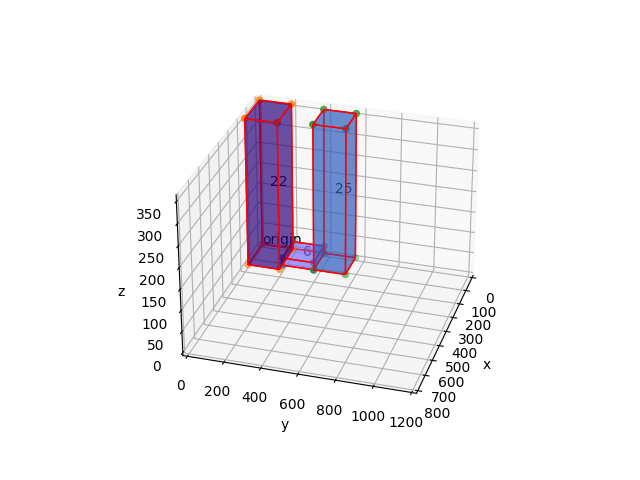

In [104]:
example = layer_pool[6]
ax = plot.get_pallet(config.pallet_lenght, config.pallet_width, example[1])
for s_id, s_coords in zip(example[2], example[3]):
    dims = superitems.iloc[s_id].lenght, superitems.iloc[s_id].width, superitems.iloc[s_id].height
    ax = plot.add_product_to_pallet(ax, s_id, (s_coords[0], s_coords[1], 0), dims)
    plt.show()